In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from torch_geometric import utils
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)

In [4]:
edge_index = torch.tensor([[0, 1, 2, 0, 3],
                           [1, 0, 1, 3, 2]], dtype=torch.long)

In [5]:
# [num_edges, num_edge_features]
edge_attr = torch.tensor([4,10,3,1,5],dtype=torch.float)

In [6]:
g = Data(x=x,edge_index=edge_index,edge_attr=edge_attr,y=y)

In [7]:
def get_width(attr):
    return np.sqrt(np.sum(np.square(attr)))

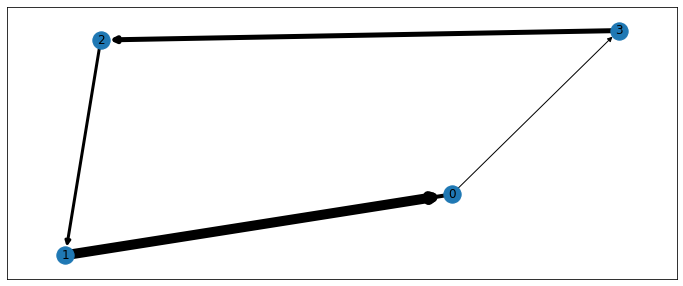

In [8]:
viz = utils.to_networkx(g,edge_attrs=["edge_attr"])
# labels = [i for i in dict(viz.nodes).keys()]
labels = {i:i for i in dict(viz.nodes).keys()}
width = [get_width(i['edge_attr']) for i in dict(viz.edges).values()]
fig, ax = plt.subplots(figsize=(12,5))
pos = nx.spring_layout(viz)
nx.draw_networkx_nodes(viz, pos, ax = ax, labels=True)
nx.draw_networkx_edges(viz, pos, ax=ax,width=width,style="solid")
_ = nx.draw_networkx_labels(viz, pos, labels, ax=ax)

In [9]:
viz.adj

AdjacencyView({0: {1: {'edge_attr': 4.0}, 3: {'edge_attr': 1.0}}, 1: {0: {'edge_attr': 10.0}}, 2: {1: {'edge_attr': 3.0}}, 3: {2: {'edge_attr': 5.0}}})

In [3]:
from torch_geometric.nn import GCNConv
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch_geometric.utils import add_remaining_self_loops
from torch_scatter import scatter_add

In [9]:
conv1 = GCNConv(2, 2)

In [85]:
op = conv1(g.x,g.edge_index,g.edge_attr)

tensor([[0, 1, 2, 0, 3, 0, 1, 2, 3],
        [1, 0, 1, 3, 2, 0, 1, 2, 3]])
tensor([[ 1.1556e+00,  8.2493e-03],
        [ 1.6986e+00,  3.4705e+00],
        [-1.3730e-01,  5.4336e+00],
        [ 8.9745e+00, -5.8645e+00]], grad_fn=<MmBackward>)
tensor([[ 1.1556e+00,  8.2493e-03],
        [ 1.6986e+00,  3.4705e+00],
        [-1.3730e-01,  5.4336e+00],
        [ 1.1556e+00,  8.2493e-03],
        [ 8.9745e+00, -5.8645e+00],
        [ 1.1556e+00,  8.2493e-03],
        [ 1.6986e+00,  3.4705e+00],
        [-1.3730e-01,  5.4336e+00],
        [ 8.9745e+00, -5.8645e+00]], grad_fn=<IndexSelectBackward>)
tensor([0.4264, 1.0660, 0.4330, 0.2132, 1.4434, 0.0909, 0.1250, 0.1667, 0.5000])
tensor([[0.4264],
        [1.0660],
        [0.4330],
        [0.2132],
        [1.4434],
        [0.0909],
        [0.1250],
        [0.1667],
        [0.5000]])
msg
tensor([[ 4.9276e-01,  3.5175e-03],
        [ 1.8107e+00,  3.6995e+00],
        [-5.9452e-02,  2.3528e+00],
        [ 2.4638e-01,  1.7588e-03],
        [ 

In [54]:
op

tensor([[ 1.9157,  3.7003],
        [ 0.6456,  2.7901],
        [12.9307, -7.5591],
        [ 4.7336, -2.9305]], grad_fn=<AddBackward0>)

In [50]:
def gcn_norm(edge_index,edge_weight=None,fill_value=1.,num_nodes=None, dtype=torch.float):
    num_nodes = maybe_num_nodes(edge_index, num_nodes)

    if edge_weight is None:
        edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype,
                                 device=edge_index.device)

    if True:
        edge_index, tmp_edge_weight = add_remaining_self_loops(
            edge_index, edge_weight, fill_value, num_nodes)
        assert tmp_edge_weight is not None
        print(edge_index)
        print(tmp_edge_weight)
        edge_weight = tmp_edge_weight

    row, col = edge_index[0], edge_index[1]
    deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
    print(deg)
    deg_inv_sqrt = deg.pow_(-0.5)
    deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
    print(deg_inv_sqrt)
    print(deg_inv_sqrt[row])
    print(deg_inv_sqrt[col])
    return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

In [51]:
edge_index, edge_weight = gcn_norm(g.edge_index,g.edge_attr)

tensor([[0, 1, 2, 0, 3, 0, 1, 2, 3],
        [1, 0, 1, 3, 2, 0, 1, 2, 3]])
tensor([ 4., 10.,  3.,  1.,  5.,  1.,  1.,  1.,  1.])
tensor([11.,  8.,  6.,  2.])
tensor([0.3015, 0.3536, 0.4082, 0.7071])
tensor([0.3015, 0.3536, 0.4082, 0.3015, 0.7071, 0.3015, 0.3536, 0.4082, 0.7071])
tensor([0.3536, 0.3015, 0.3536, 0.7071, 0.4082, 0.3015, 0.3536, 0.4082, 0.7071])


In [47]:
edge_weight

tensor([0.4264, 1.0660, 0.4330, 0.2132, 1.4434, 0.0909, 0.1250, 0.1667, 0.5000])

In [64]:
import torch
from torch_scatter.utils import broadcast
from typing import Optional, Tuple

In [98]:
@torch.jit.script
def scatter_sum(src: torch.Tensor, index: torch.Tensor, dim: int = -1,
                out: Optional[torch.Tensor] = None,
                dim_size: Optional[int] = None) -> torch.Tensor:
    index = broadcast(index, src, dim)
    if out is None:
        size = src.size()
        if dim_size is not None:
            size[dim] = dim_size
        elif index.numel() == 0:
            size[dim] = 0
        else:
            size[dim] = int(index.max()) + 1
        out = torch.zeros(size, dtype=src.dtype, device=src.device)
        return out.scatter_add_(dim, index, src)
    else:
        return out.scatter_add_(dim, index, src)

In [99]:
scatter_sum(g.x[edge_index[1]],edge_index[1],dim=-2,dim_size=4)

tensor([[ 4.,  2.],
        [15., 18.],
        [ 6., 14.],
        [24.,  0.]])

In [90]:
g.x[edge_index[1]]

tensor([[ 5.,  6.],
        [ 2.,  1.],
        [ 5.,  6.],
        [12.,  0.],
        [ 3.,  7.],
        [ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]])

In [100]:
edge_index[1]

tensor([1, 0, 1, 3, 2, 0, 1, 2, 3])